<a href="https://colab.research.google.com/github/Maxouuu4/test_git/blob/main/math0487_nb3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📓 Notebook 3 : **Biais et variance des estimateurs**

## Objectifs 🎯

Les objectifs de ce notebook sont les suivants :
- *comprendre* le concept de compromis entre biais et variance d'un estimateur ;
- *comprendre* les concepts de fonction de perte et de risque ;
- *comprendre* les liens entre biais, variance, MSE et consistance d'un estimateur.


## Contexte 🔍

Dans ce troisième notebook, nous allons aborder différents concepts liés au compromis entre biais et variance. Nous n'allons pas utiliser d'ensemble de données cette fois-ci, car les concepts illustrés étant principalement théoriques, il nous sera plus facile de simuler des données à partir d'un processus générateur connu et contrôlé (_i.e._ une distribution fixée).

Commençons par importer les librairies dont nous aurons besoin. 👇

In [ ]:
import numpy as np
from ipywidgets import IntSlider, FloatSlider, Dropdown, Output, VBox, interact, interactive, Checkbox, HBox, Button, interactive_output
from IPython.display import display
from scipy.stats import gaussian_kde, norm
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.patches import Patch
import pandas as pd

## Biais et variance : introduction 👋

Dans le notebook suivant, nous allons étudier deux méthodes pour estimer de manière ponctuelle un estimand (bien souvent, le paramètre d'un modèle statistique) : la méthode des moments (MoM) et la méthode du maximum de vraisemblance (MLE). Nous allons également étudier les propriétés de l'estimateur du MLE, notamment en terme de biais.

> Afin de nous concentrer sur les principes derrière ces méthodes, nous jugerons de la qualité de nos estimations de manière empirique, en comparant par exemple le modèle paramétrisé grâce à notre méthode et l'histogramme de la variable à modéliser. Cependant, cela ne constitue pas un critère quantitatif clair pour caractériser la qualité de nos estimateurs, et sans un tel critère, il est souvent difficile de faire un choix d'estimateur éclairé...

Nous allons donc voir ensemble dans ce notebook comment analyser *quantitativement* et de manière fondée la qualité d'estimateurs afin de pouvoir les comparer, au travers des notions de biais, variance, MSE, fonction de perte et risque.

> Pour rappel, lorsque l'on estime un _estimand_ $\theta$ à l'aide d'un _estimateur_ $\hat{{\theta}}$, le biais de cet estimateur est défini par $$\text{bias}(\hat{\theta}) = E(\hat{\theta}) - \theta,$$ où l'estimateur est bien une variable aléatoire (se cristalisant pour chaque échantillon considéré). La variance est elle définie par $$\text{Var}(\hat{\theta}) = E((\hat{\theta} - E({\hat{\theta}}))^2).$$  

Commençons en douceur avec un exemple introductif afin de rafraîchir ces différentes notions. 👇




### Estimation de densité par noyau (KDE)

L’estimation de densité par noyau (en anglais, kernel density estimation ou KDE) est une méthode non-paramétrique d’estimation de la densité de probabilité d’une variable aléatoire. Elle diffère de l'histogramme en appliquant un noyau continu en chaque point de donnée, permettant ainsi d'obtenir une estimation sur tout le support de la variable alétoire étudiée.
> 🤔 Un noyau ?

 Le noyau $K(x, x')$ (_kernel_ en anglais) peut par exemple représenter une densité normale, ou encore une fonction rectangulaire, et correspond à une mesure de similarité entre $x$ et $x'$ : la valeur du noyau sera grande si $x$ et $x'$ sont proches (selon cette mesure), et petite s'ils sont éloignés (selon cette mesure). Par exemple, si l'on définit un noyau normal $$K(x, x')=\frac{1}{\sqrt{2\pi}}e^{-\frac{(x-x')^2}{2\sigma^2}},$$
on obtient une fonction qui, pour $x'$ fixé, représente une densité normale centrée en $x'$ et associant une valeur de similitude pour toutes les valeurs de $x$. Dans la suite, on notera les noyaux $K(u)$ (donc avec une seule entrée), de sorte que le noyau ci-dessus se réécrit
$$K(u)=\frac{1}{\sqrt{2\pi}}e^{-\frac{(u)^2}{2\sigma^2}},$$ pour l'entrée $u=x-x'$.

> 🤔 Et donc, quel rapport avec un histogramme ?

Et bien, si, à la place d'estimer la densité d'un point $x$ en considérant la proportion d'observations qui se trouvent autour de $x$ (comme on le fait avec un histogramme), on associe à chaque observation une gaussienne (par exemple, mais cela dépend du noyau utilisé), et que l'on somme toutes ces contributions de la manière suivante: $$\frac{1}{nh}\sum_{i=1}^{n}K\left(\frac{x-x_i}{h}\right),$$ où $h$ est le paramètre de _bandwidth_ ou "fenêtre", on se retrouve avec une estimation **continue** de la densité de probabilité de la variable étudiée !

Mais assez bavardé, voyons ensemble comment cette KDE se construit. 👀

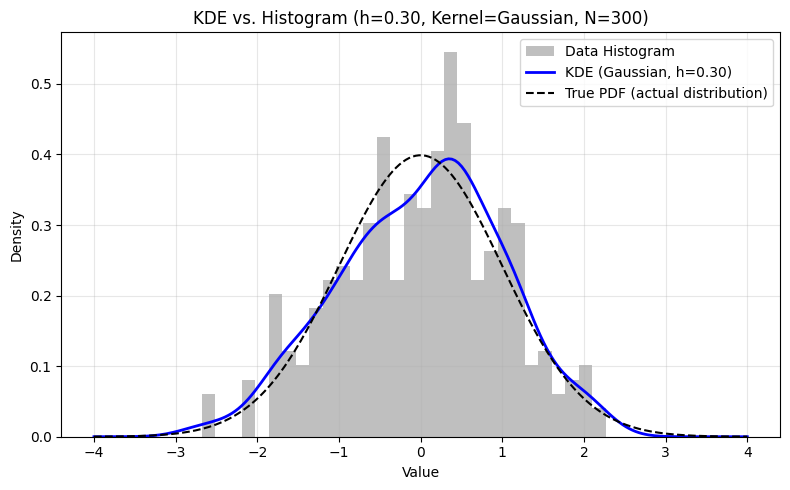

In [ ]:
# True distribution parameters
true_mu, true_sigma = 0, 1

# Global variables for data
_cached_data = None
_cached_x_grid = None
_cached_true_pdf = None
_current_n_size = -1

def generate_data(sample_size):
    global _cached_data, _cached_x_grid, _cached_true_pdf, _current_n_size
    if sample_size != _current_n_size:
        _current_n_size = sample_size
        _cached_data = np.random.normal(true_mu, true_sigma, size=sample_size)
        min_val = _cached_data.min()
        max_val = _cached_data.max()
        plot_min = min(min_val - 1, -4)
        plot_max = max(max_val + 1, 4)
        _cached_x_grid = np.linspace(plot_min, plot_max, 200)
        _cached_true_pdf = norm.pdf(_cached_x_grid, loc=true_mu, scale=true_sigma)
    return _cached_data, _cached_x_grid, _cached_true_pdf

# Kernels
def gaussian_kernel(u):
    return 1/np.sqrt(2*np.pi) * np.exp(-0.5*u**2)

def epanechnikov_kernel(u):
    return np.where(np.abs(u) <= 1, 0.75 * (1 - u**2), 0)

def uniform_kernel(u):
    return np.where(np.abs(u) <= 1, 0.5, 0)

kernels = {
    "Gaussian": gaussian_kernel,
    "Epanechnikov": epanechnikov_kernel,
    "Uniform": uniform_kernel
}

# KDE
def kde_estimate(x_eval, data_points, h, kernel_func):
    return np.mean(kernel_func((x_eval[:, None] - data_points[None, :]) / h), axis=1) / h

# Widgets
n_slider = IntSlider(min=10, max=500, step=10, value=300, description="Sample Size")
bw_slider = FloatSlider(value=0.3, min=0.05, max=1.5, step=0.05, description="Bandwidth h")
kernel_selector = Dropdown(options=list(kernels.keys()), value="Gaussian", description="Kernel")
show_individual_kernels_checkbox = Checkbox(value=False, description='Show Individual Kernels')
out = Output()

# Update function
def update_plot(n_size, h=0.3, kernel_name="Gaussian", show_individual_kernels=False):
    data, x_grid, true_pdf = generate_data(n_size)
    n = len(data)

    selected_kernel_func = kernels[kernel_name]

    kde = kde_estimate(x_grid, data, h, selected_kernel_func)

    with out:
        out.clear_output(wait=True)
        fig, ax = plt.subplots(figsize=(8, 5))

        ax.hist(data, bins=30, density=True, alpha=0.5, label="Data Histogram", color="gray")

        if show_individual_kernels:
            for d_point in data:
                individual_kernel_contribution = selected_kernel_func((x_grid - d_point) / h) / (n * h)
                ax.plot(x_grid, individual_kernel_contribution, color="purple", lw=0.5, alpha=0.5)

        ax.plot(x_grid, kde, color="blue", lw=2, label=f"KDE ({kernel_name}, h={h:.2f})")

        ax.plot(x_grid, true_pdf, "k--", lw=1.5, label="True PDF (actual distribution)")

        ax.set_title(f"KDE vs. Histogram (h={h:.2f}, Kernel={kernel_name}, N={n_size})")
        ax.set_xlabel("Value")
        ax.set_ylabel("Density")
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

interactive_plot = interactive(update_plot, n_size=n_slider, h=bw_slider, kernel_name=kernel_selector, show_individual_kernels=show_individual_kernels_checkbox)
display(VBox([HBox([n_slider, bw_slider, kernel_selector]), show_individual_kernels_checkbox, out]))

update_plot(n_slider.value, bw_slider.value, kernel_selector.value, show_individual_kernels_checkbox.value)


❓À quoi correspond le paramètre de _bandwidth_ $h$ ? Quelle est son influence ? Opteriez-vous plutôt pour une valeur de $h$ élevée, faible, ou un compromis ? Voyez-vous un lien entre ce paramètre et la notions de biais ?

> 🧠 Écrivez ici ce que vous en pensez !

Bon, c'est bien beau de découvrir de nouvelles méthodes, maisrevenons à nos moutons : le biais et la variance. 👇

Simulons la génération d'un grand nombre d'échantillons, générons pour chacun d'eux la KDE, et visualisons la KDE moyenne et l'écart-type. En tout point, on peut donc calculer le biais et la variance de la KDE. Évidemment, ceci n'est possible que parce qu'on considère la "vraie" distribution comme connue. 😉

Voyons ensemble quelle influence a le paramètre $h$. 👀

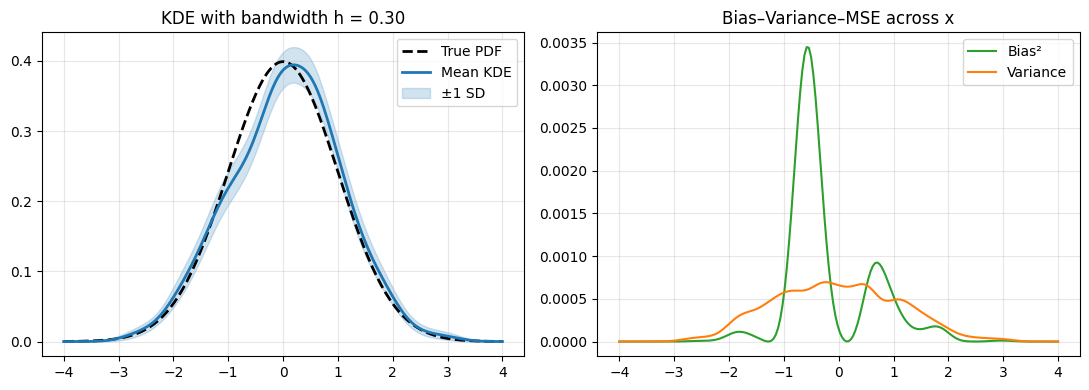

In [ ]:
# Parameters
n = 300
true_mu, true_sigma = 0, 1
data = np.random.normal(true_mu, true_sigma, size=n)

# Grid for evaluation
x_grid = np.linspace(-4, 4, 200)
true_pdf = norm.pdf(x_grid, loc=true_mu, scale=true_sigma)

# Widgets
bw_slider = FloatSlider(value=0.3, min=0.05, max=1.5, step=0.05, description="Bandwidth h")
out = Output()

# KDE
def gaussian_kernel(u):
    return 1/np.sqrt(2*np.pi) * np.exp(-0.5*u**2)

def kde_estimate(x, data, h):
    """Compute KDE at points x given data and bandwidth h."""
    return np.mean(gaussian_kernel((x[:, None] - data[None, :]) / h), axis=1) / h

# Update function
def update(h=0.3):
    reps = 200
    estimates = np.zeros((reps, len(x_grid)))
    for i in range(reps):
        sample = np.random.choice(data, size=n, replace=True)
        estimates[i, :] = kde_estimate(x_grid, sample, h)

    mean_est = np.mean(estimates, axis=0)
    bias = mean_est - true_pdf
    var = np.var(estimates, axis=0)

    with out:
        out.clear_output(wait=True)
        fig, axs = plt.subplots(1, 2, figsize=(11, 4))

        # KDE & PDF
        axs[0].plot(x_grid, true_pdf, "k--", lw=2, label="True PDF")
        axs[0].plot(x_grid, mean_est, "C0", lw=2, label="Mean KDE")
        axs[0].fill_between(x_grid, mean_est - np.sqrt(var), mean_est + np.sqrt(var),
                            color="C0", alpha=0.2, label="±1 SD")
        axs[0].set_title(f"KDE with bandwidth h = {h:.2f}")
        axs[0].legend()
        axs[0].grid(True, alpha=0.3)

        # Bias & Variance
        axs[1].plot(x_grid, bias**2, label="Bias²", color="C2")
        axs[1].plot(x_grid, var, label="Variance", color="C1")
        axs[1].set_title("Bias–Variance–MSE across x")
        axs[1].legend()
        axs[1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

interactive_plot = interactive(update, h=bw_slider)
display(VBox([bw_slider, out]))
update()


❓Voyez-vous désormais un lien plus précis entre le paramètre $h$ et le biais ? Et avec la variance ?

> 🧠 Écrivez ici ce que vous en pensez !

## Fonction de perte et risque 📉

Bien, maintenant que vous avez un peu d'intuition quant au compromis entre biais et variance, et avant de s'y intéresser plus en profondeur, prenons le temps d'introduire deux notions indissociables de l'analyse de la qualité d'un estimateur : la **fonction de perte** et le **risque** associé.

> Nous avons déjà rencontré la notion de fonction de perte (ou _loss function_ en anglais). Si si, rappelez vous, dans le notebook précédent, lorsque nous avons illustré la méthode de la descente de gradient. 😉

Pour rappel, cette fonction représente la perte, le "coût" associé à un choix d'estimateur $\hat{\theta}$ pour estimer un estimand $\theta$. On note cette fonction de manière générale $$\text{Loss}(\theta, \hat{\theta}),$$
qui est positive et vaut zéro pour $\hat{\theta}=\theta$.

Nous allons dans ce notebook nous intéresser à deux fonctions de pertes très connues et utilisées en statistiques et en machine learning : les distances $L^1$ définie comme
$$||\theta - \hat{\theta}||_1 = |\theta - \hat{\theta}| $$ et $L^2$ définie comme
$$||\theta - \hat{\theta}||_2 = (\theta - \hat{\theta})^2. $$

Voyons ensemble comment ces différentes fonctions pénalisent les valeurs du paramètre 👀

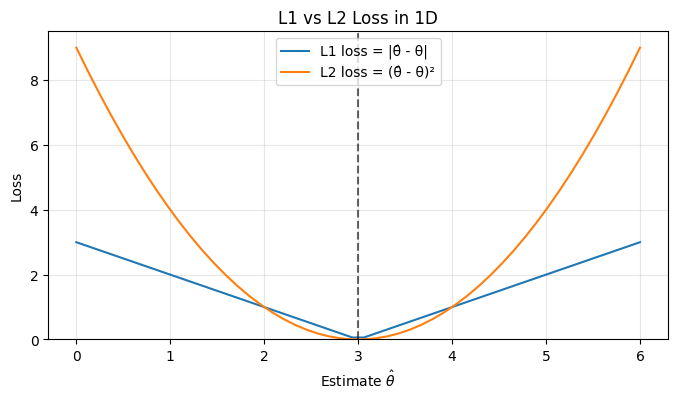

In [ ]:
# Estimates range
estimates = np.linspace(0, 6, 50)

# True theta slider
true_theta_val = FloatSlider(min=0, max=6, step=0.1, value=3.0, description="True Theta")

out = Output()

# Update function
def plot_loss_1d(true_theta_val):
  with out:
    out.clear_output(wait=True)
    df = pd.DataFrame({
        "theta_hat": estimates,
        "theta_true": true_theta_val,
    })
    df["L1_loss"] = np.abs(df["theta_hat"] - df["theta_true"])
    df["L2_loss"] = (df["theta_hat"] - df["theta_true"])**2

    plt.figure(figsize=(8,4))
    plt.plot(df["theta_hat"], df["L1_loss"], label="L1 loss = |θ̂ - θ|", color="C0")
    plt.plot(df["theta_hat"], df["L2_loss"], label="L2 loss = (θ̂ - θ)²", color="C1")
    plt.axvline(true_theta_val, color="k", linestyle="--", alpha=0.6)
    plt.title("L1 vs L2 Loss in 1D")
    plt.xlabel(r"Estimate $\hat{ {\theta}}$")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.ylim(0, 9.5)
    plt.show()

true_theta_val.observe(lambda x: plot_loss_1d(x["new"]), "value")
plot_loss_1d(true_theta_val.value)  # initial call

display(VBox([true_theta_val, out]))

❓Pour des estimations fort éloignées de la vraie valeur du paramètre, quelle fonction est la plus pénalisante ? Et pour des valeurs plus proches ? Avez-vous une idée de répercussions que cela peut avoir ?



> 🧠 Écrivez ici ce que vous en pensez !


Évidemment, ces fonctions ne se limitent pas à un seul paramètre, et nous pouvons également les définir pour des vecteurs de paramètres $\mathbf{\theta} = \{\theta_1, \ldots, \theta_k\}$ et $\mathbf{\hat{{\theta}}} = \{\hat{\theta_1}, \ldots, \hat{\theta_k}\}$ :
$$||\mathbf{\theta} - \mathbf{\hat{\theta}}||_1 = \sum_{i=1}^{k}|\theta_i - \hat{\theta}_i| $$
et
$$||\mathbf{\theta} - \mathbf{\hat{\theta}}||_2 = \sum_{i=1}^{k}(\theta_i - \hat{\theta}_i)^2. $$

Voyons ensemble à quoi ressemble le paysage dessiné par ces fonctions pour un paramètre à deux dimensions (nous utiliserons le modèle normal), et voyons où se situent des estimations faites à partir de différents échantillons. 👀

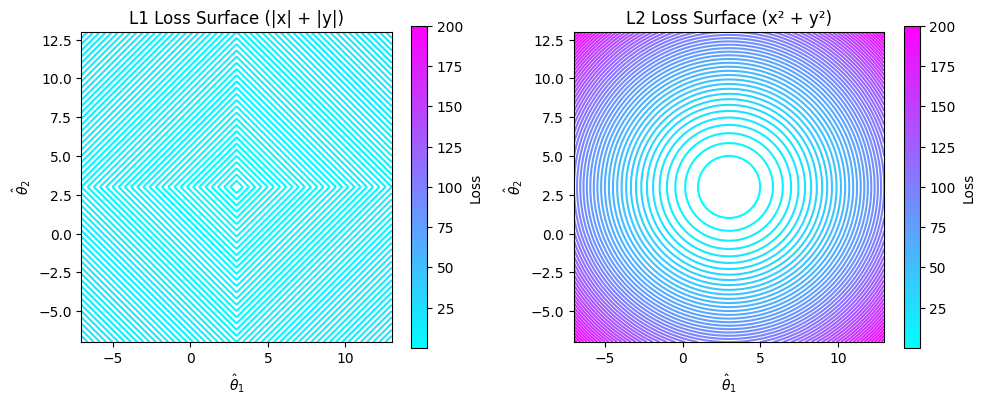

In [ ]:
# Synthetic parameter points
data = np.random.normal(loc=3.0, scale=2.5, size=(2, 1000))
data = pd.DataFrame({
    "theta_hat_0": data[0],
    "theta_hat_1": data[1],
})
theta_true = np.array([data["theta_hat_0"].mean(), data["theta_hat_1"].mean()])

# Compute loss surfaces
x = np.linspace(theta_true[0]-10, theta_true[0]+10, 500)
y = np.linspace(theta_true[1]-10, theta_true[1]+10, 500)
X, Y = np.meshgrid(x, y)

L1_surface = np.abs(X - theta_true[0]) + np.abs(Y - theta_true[1])
L2_surface = (X - theta_true[0])**2 + (Y - theta_true[1])**2

# Color maps
combined_surface = np.array([L1_surface, L2_surface])
min_, max_ = np.amin(combined_surface), np.amax(combined_surface)
normalize = Normalize(vmin=min_, vmax=max_)
cmap = "cool"

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# L1 loss contour
c1 = axes[0].contour(X, Y, L1_surface, levels=50, cmap=cmap, vmin=min_, vmax=max_)
plt.colorbar(ScalarMappable(norm=normalize, cmap=cmap), ax=axes[0], label="Loss")
axes[0].set_title("L1 Loss Surface (|x| + |y|)")
axes[0].set_xlabel(r"$\hat{\theta}_1$")
axes[0].set_ylabel(r"$\hat{\theta}_2$")
axes[0].set_aspect("equal")

# L2 loss contour
c2 = axes[1].contour(X, Y, L2_surface, levels=50, cmap=cmap, vmin=min_, vmax=max_)
plt.colorbar(ScalarMappable(norm=normalize, cmap=cmap), ax=axes[1], label="Loss")
axes[1].set_title("L2 Loss Surface (x² + y²)")
axes[1].set_xlabel(r"$\hat{\theta}_1$")
axes[1].set_ylabel(r"$\hat{\theta}_2$")
axes[1].set_aspect("equal")

plt.tight_layout()
plt.close()

out = Output()

def on_sample_clicked(b):
    # Randomly sample
    sample = data.sample(1).iloc[0]
    theta_hat_0 = sample["theta_hat_0"]
    theta_hat_1 = sample["theta_hat_1"]

    L1_val = np.abs(theta_hat_0 - theta_true[0]) + np.abs(theta_hat_1 - theta_true[1])
    L2_val = (theta_hat_0 - theta_true[0])**2 + (theta_hat_1 - theta_true[1])**2

    with out:
        out.clear_output(wait=True)
        axes[0].scatter(theta_hat_0, theta_hat_1, c=[L1_val], cmap=cmap, norm=normalize, alpha=0.8)
        axes[1].scatter(theta_hat_0, theta_hat_1, c=[L2_val], cmap=cmap, norm=normalize, alpha=0.8)
        display(fig)

button = Button(description="Sample", button_style="info")
button.on_click(on_sample_clicked)

with out:
    out.clear_output(wait=True)
    display(fig)

display(VBox([button, out]))


❓ Comment se comparent les deux fonctions de perte ? La $L^1$ est-elle constante pour tous les couples $(\hat{\theta}_1, \hat{\theta}_2)$ ?

❓ Pouvez-vous expliquer la forme en "diamant" des contours de la $L^1$ ?

> 🧠 Écrivez ici ce que vous en pensez !

Bien, maintenant que vous vous êtes familiarisés avec ces fonctions de perte, parlons de risque !

> 😎 Pas de danger, le risque est simplement défini comme l'espérance de la fonction de perte, où l'espérance est calculée par rapport à la distribution $f_{\theta}$ des données observées $Y$ : $$R(\theta) = \int_{Y}\text{Loss}(\theta, \hat{\theta}(y))\; dP_{\theta}(y).$$   

Pour la fonction $L^2$, ce risque est appelé _Mean squared error_, puisque c'est l'espérance de l'erreur "au carré" $L^2$, souvent abrégé en MSE. ⚠️ Notez que l'on considère ici le risque comme une fonction de l'_estimand_ $\theta$, mais cette fonction dépend évidemment de l'_estimateur_ $\hat{\theta}$ choisi.

Dans la suite de ce notebook, pour illustrer le compromis entre biais et variance, nous allons introduire un estimateur de la moyenne comprenant un paramètre de _shrinkage_ $c$, et défini par $$\hat{\theta} = c\bar{Y}.$$ Nous allons voir l'influence qu'a ce paramètre, et pourquoi cet estimateur peut être utile. Nous allons évidemment nous intéresser au compromis entre biais et variance en fonction de la valeur de ce paramètre, comme nous l'avons fait en introduction avec le paramètre $h$ pour la KDE.

Voyons ainsi comment se comporte le risque des deux fonctions de pertes qui nous intéressent pour différentes valeurs de $c$, et comparons cela à $\hat{\theta}=\bar{Y}$. 👀

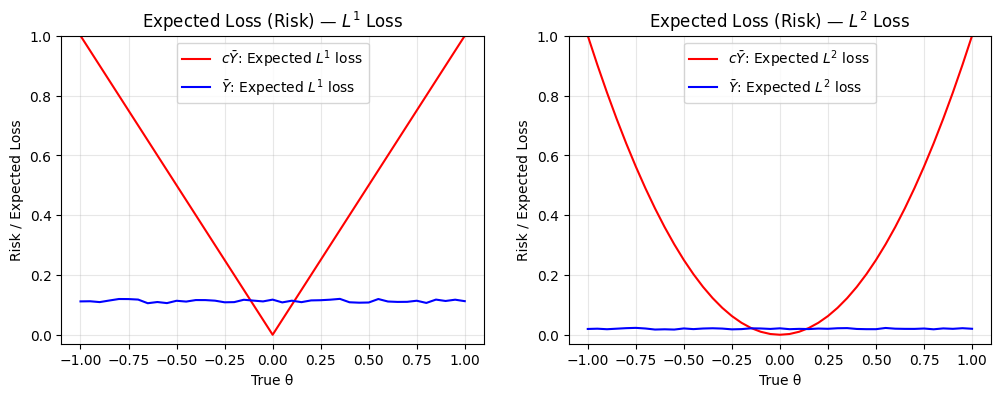

In [ ]:
# Synthetic data
population = np.random.normal(loc=0.0, scale=1.0, size=10_000)
df = pd.DataFrame({"x": population})

# Simulation parameters
thetas = np.linspace(-1, 1, 41)
n_samples = 50       # sample size per experiment
n_reps = 500         # number of repetitions per theta value

# Widget
c_slider = FloatSlider(min=0.0, max=1.0, step=0.01, value=0., description="c (shrinkage)")

out = Output()

def compute_risks(c_val):
  records = []
  for theta in thetas:
      losses_L1 = []
      losses_L2 = []
      losses_L1_ = []
      losses_L2_ = []

      for _ in range(n_reps):
          # Sample
          sample = np.random.normal(loc=theta, scale=1.0, size=n_samples)

          # Estimates
          theta_hat = c_val * np.mean(sample)
          classic_est = np.mean(sample)

          # Losses
          losses_L1.append(abs(theta_hat - theta))
          losses_L2.append((theta_hat - theta)**2)

          losses_L1_.append(abs(classic_est - theta))
          losses_L2_.append((classic_est - theta)**2)


      # Compute expected losses (risk)
      R_L1 = np.mean(losses_L1)
      R_L1_std = np.std(losses_L1)
      R_L2 = np.mean(losses_L2)
      R_L2_std = np.std(losses_L2)
      R_L1_ = np.mean(losses_L1_)
      R_L1_std_ = np.std(losses_L1_)
      R_L2_ = np.mean(losses_L2_)
      R_L2_std_ = np.std(losses_L2_)

      records.append({
          "theta": theta,
          "risk_L1": R_L1,
          "risk_L2": R_L2,
          "risk_L1_std": R_L1_std,
          "risk_L2_std": R_L2_std,
          "risk_L1_": R_L1_,
          "risk_L2_": R_L2_,
          "risk_L1_std_": R_L1_std_,
          "risk_L2_std_": R_L2_std_,
      })

  results = pd.DataFrame(records)
  return results

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)
plt.close()

# Update function
def plot_results(c_val):

  results = compute_risks(c_val)

  with out:
    out.clear_output(wait=True)
    axes[0].clear()
    axes[1].clear()

    # L1 Risk
    axes[0].plot(results["theta"], results["risk_L1"], label=r"$c\bar{Y}$: Expected $L^1$ loss", color="red")
    axes[0].plot(results["theta"], results["risk_L1_"], label=r"$\bar{Y}$: Expected $L^1$ loss", color="blue")
    axes[0].set_title(r"Expected Loss (Risk) — $L^1$ Loss")
    axes[0].set_xlabel("True θ")
    axes[0].set_ylabel("Risk / Expected Loss")
    axes[0].grid(alpha=0.3)
    axes[0].set_ylim(-.03, 1.)
    axes[0].legend()

    # L2 (MSE) Risk
    axes[1].plot(results["theta"], results["risk_L2"], label=r"$c\bar{Y}$: Expected $L^2$ loss", color="red")
    axes[1].plot(results["theta"], results["risk_L2_"], label=r"$\bar{Y}$: Expected $L^2$ loss", color="blue")
    axes[1].set_title(r"Expected Loss (Risk) — $L^2$ Loss")
    axes[1].set_xlabel("True θ")
    axes[1].set_ylabel("Risk / Expected Loss")
    axes[1].grid(alpha=0.3)
    axes[1].set_ylim(-.03, 1.)
    axes[1].legend()
    display(fig)

plot_results(c_slider.value)

c_slider.observe(lambda x: plot_results(x["new"]), "value")
display(VBox([c_slider, out]))

❓Pour les deux risques, quel effet a le facteur $c$ sur la **forme générale** de la fonction ? Quelle forme a la courbe en fonction de $\theta$ ? En particulier, qu'observez-vous pour $c$ proche de $1$ ? Et pour $c$ proche de $0$ ? À quoi correspondent ces cas limites ? Pouvez-vous lier cela au biais de l'estimateur ?

❓Que pouvez-vous observer quant à la qualité de l'estimateur, en fonction de $c$ ? En particulier, comparez à l'estimateur $\bar{Y}$. Voyez-vous l'intérêt d'introduire le facteur $c$ ? A-t-il un intérêt dans certains cas ou de manière générale ? Autrement dit, l'utiliseriez-vous d'office, ou bien seulement dans certains cas ?

> 🧠 Écrivez ici ce que vous en pensez !

## Décomposition de l'erreur et compromis biais et variance ⚖️

Comme déjà mentionné, le risque pour la fonction de perte $L^2$ correspond à la _mean squared error_, ou MSE. À partir de maintenant et jusqu'à la fin du notebook (courage !), nous n'allons plus nous intéresser qu'à cette MSE car, pour ce cas spécifique, le résultat suivant est particulièrement intéressant (et pratique) : $$\text{MSE}(\hat{\theta}) = \text{Var}(\hat{\theta}) + [\text{bias}(\hat{\theta})]^2$$

⚠️ Notez que cette fois, on considère l'_estimand_ $\theta$ fixé, et le risque dépend uniquement de l'_estimateur_ $\hat{\theta}$.

> 📍 Cette décomposition du risque pour la fonction de perte $L^2$ est ce que l'on appelle la **décomposition biais-variance**, et, au delà de constituer un résultat très important, elle motive l'utilisation de la MSE pour comparer différents estimateurs de manière quantitative, et constitue ainsi une mesure indispensable pour leur sélection.

Reprenons la visualisation précédente, pour la fonction de perte $L^2$ uniquement, et voyons ensemble comment biais et variance influencent la MSE pour différentes valeur de $c$ 👀

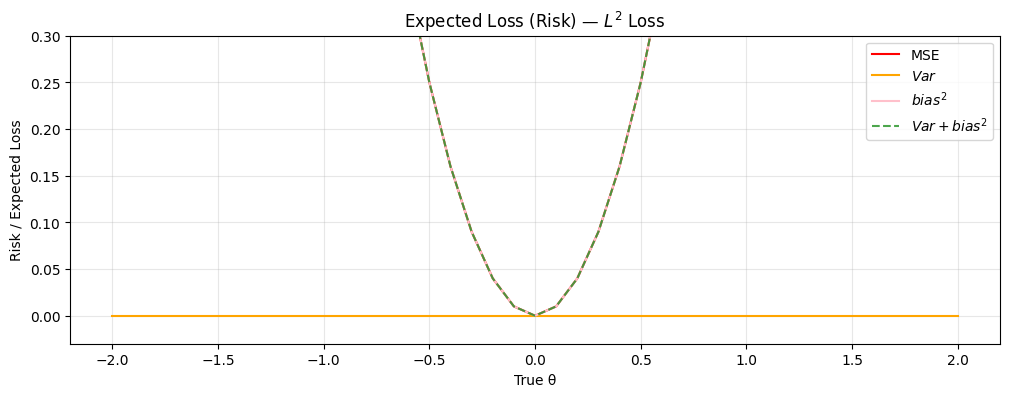

In [ ]:
# Synthetic data
population = np.random.normal(loc=0.0, scale=1.0, size=10_000)
df = pd.DataFrame({"x": population})

# Simulation parameters
thetas = np.linspace(-2, 2, 41)
n_samples = 50
n_reps = 500

# Widget
c_slider = FloatSlider(min=0.0, max=1.0, step=0.01, value=0., description=r"c (shrinkage)")

out = Output()

# Risk function
def compute_risks(c_val):
  records = []
  for theta in thetas:
      losses_L2 = []
      estimates = []

      for _ in range(n_reps):
          # Sample
          sample = np.random.normal(loc=theta, scale=1.0, size=n_samples)

          # Estimate
          theta_hat = c_val * np.mean(sample)
          estimates.append(theta_hat)

          # Loss
          losses_L2.append((theta_hat - theta)**2)

      # Risk
      R_L2 = np.mean(losses_L2)
      R_L2_std = np.std(estimates)
      R_L2_mean = np.mean(estimates)

      records.append({
          "theta": theta,
          "risk_L2": R_L2,
          "risk_L2_std": R_L2_std,
          "risk_L2_mean": R_L2_mean,
      })

  results = pd.DataFrame(records)
  return results

fig, ax = plt.subplots(1, 1, figsize=(12, 4), sharey=False)
plt.close()

# Update function
def plot_results(c_val):

  results = compute_risks(c_val)

  with out:
    out.clear_output(wait=True)
    ax.clear()

    ax.plot(results["theta"], results["risk_L2"], label="MSE", color="red")
    variance = results["risk_L2_std"]**2
    ax.plot(results["theta"], variance, label=r"$Var$", color="orange")
    bias_squared = (results["risk_L2_mean"] - results["theta"])**2
    ax.plot(results["theta"], bias_squared, label=r"$bias^2$", color="pink")
    ax.plot(results["theta"], variance + bias_squared, label=r"$Var + bias^2$", linestyle="dashed", color="green", alpha=.7)
    ax.set_title(r"Expected Loss (Risk) — $L^2$ Loss")
    ax.set_xlabel("True θ")
    ax.set_ylabel("Risk / Expected Loss")
    ax.grid(alpha=0.3)
    ax.legend()
    ax.set_ylim(-.03, .3)
    display(fig)

plot_results(c_slider.value) # Initial call
c_slider.observe(lambda x: plot_results(x["new"]), "value")
display(VBox([c_slider, out]))

❓ Premièrement, la relation énoncée ci-dessus est-elle bien respectée ?

❓ Qui, du biais et de la variance, domine en fonction du paramètre $c$ ? Que choisiriez-vous comme valeur de $c$ ?

❓À la lumière de ces nouvelles observations, expliquez l'intérêt d'introduire le facteur $c$ ; est-il bénéfique en terme de biais, de variance, ou les deux ? Partout ?

> 🧠 Écrivez ici ce que vous en pensez !

Bien, illustrons d'une autre manière comment le biais, la variance et donc la MSE évoluent pour différentes valeur de $c$, pour un $\theta$ donné. Nous allons donc visualiser les mêmes phénomènes que ci-dessus, mais d'un autre point de vue 👀

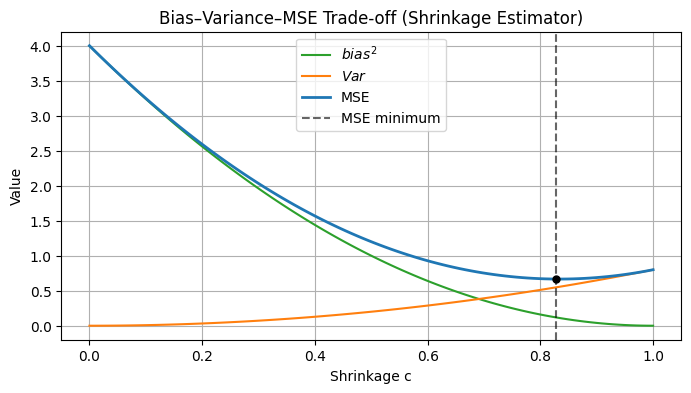

In [ ]:
# Parameters
sigma = 2.0
n_slider = FloatSlider(min=5, max=100, step=5, value=5, description="Sample size")
theta_slider = FloatSlider(min=0.0, max=10., step = 1., value=2.0, description='theta')
cs = np.linspace(0, 1, 100)

out = Output()

fig, ax = plt.subplots(1, 1, figsize=(8, 4))

plt.close()

# Update function
def update_fun(change):
  theta = theta_slider.value
  n = n_slider.value

  bias = theta * (cs - 1)
  var = cs**2 * sigma**2 / n
  mse = bias**2 + var

  with out:
    out.clear_output(wait=True)
    ax.clear()
    ax.plot(cs, bias**2, label=r"$bias^2$", color="C2")
    ax.plot(cs, var, label=r"$Var$", color="C1")
    ax.plot(cs, mse, label="MSE", color="C0", lw=2)

    ax.scatter(cs[np.argmin(mse)], mse[np.argmin(mse)], color="k", s=25, alpha=1., zorder=2)
    ax.axvline(cs[np.argmin(mse)], color="k", linestyle="--", alpha=0.6, label="MSE minimum")
    ax.set_xlabel("Shrinkage c")
    ax.set_ylabel("Value")
    ax.set_title("Bias–Variance–MSE Trade-off (Shrinkage Estimator)")
    ax.legend()
    ax.grid(True)

    display(fig)

with out:
  update_fun(None)  # Initial call

n_slider.observe(update_fun, names="value")
theta_slider.observe(update_fun, names="value")

display(VBox([HBox([n_slider, theta_slider]), out]))

❓Comment évolue la valeur optimale (selon la MSE) de $c$, en fonction de la "vraie" valeur de $\theta$ ? Est-ce en accord avec vos observations précédentes ?

❓Comment évolue la valeur optimale (selon la MSE) de $c$, en fonction de la taille d'échantillon ? Comment expliquez-vous cela ?

> 🧠 Écrivez ici ce que vous en pensez !

## Consistance et MSE 🤝

Vous êtes presque à la fin de ce notebook, bravo ! 💪

Il nous reste un dernier point à aborder : le lien entre consistance d'un estimateur et MSE.

> Pour rappel, un estimateur est dit **consistant** s'il converge _en probabilité_ vers la vraie valeur du paramètre, ce que l'on note $\hat{\theta} \overset{p}{\rightarrow} \theta$, _i.e._ si
$$\lim_{n\rightarrow \infty}P\left(\left|\hat{\theta} - \theta\right| \geq \epsilon\right) = 0,$$
c'est-à-dire que la probabilité que l'estimateur soit éloigné d'une distance $\epsilon$ de la vraie valeur du paramètre converge vers $0$, $\forall \epsilon > 0$.

Ce type de convergence ne doit pas être confondu avec la convergence _en distribution_, pour laquelle $$\lim_{n\rightarrow \infty}F_{\hat{\theta}}(\theta)=F_{\theta}(\theta)$$ où $F_{\hat{\theta}}$ représente la CDF correspondant à $\hat{\theta}$ (pour un $n$ donné). Autrement dit, ce type de convergence indique que la distribution de l'estimateur converge vers la distribution . Un exemple d'une telle convergence, que vous connaissez déjà, est le théorème central limite, qui concerne la convergence de la moyenne d'échantillon normalisée : $$\sqrt{n}(\bar{Y} - \mu) \overset{d}{\rightarrow}\mathcal{N}(0, \sigma^2)$$

> ⚠️ La convergence en probabilité implique la convergence en distribution, mais le contraire n'est pas vrai ! La convergence en distribution est ainsi plus "faible" que la convergence en probabilité.

Visualisons ensemble ces deux types de convergence pour l'estimateur de la moyenne $\hat{\theta} = \bar{Y}$, noté dans les figures $\bar{Y}_n$ pour mettre en évidence la taille d'échantillon $n$ 👀

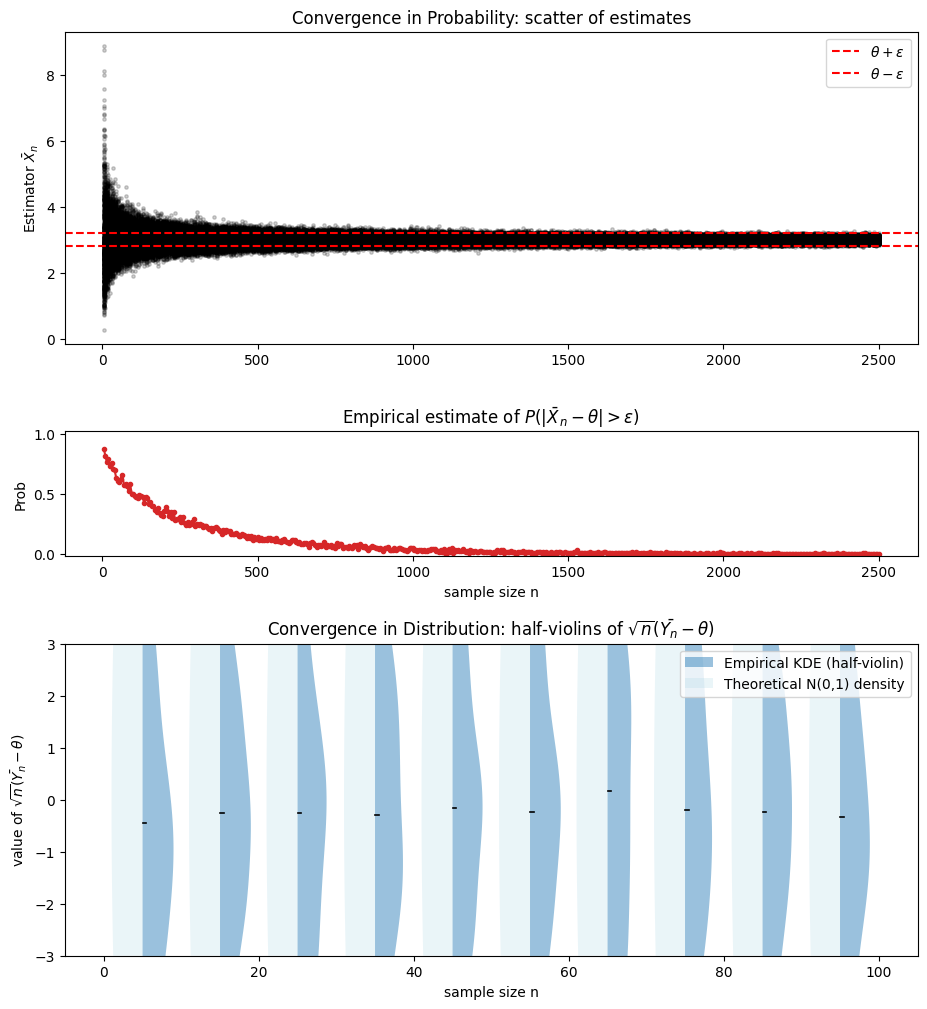

In [ ]:
# Parameters
m = 500
n_values = np.arange(5, 2501, 5)
theta = 3.0 # scale parameter of the exponential used below (1/lambda)

# Convergence in distribution subset
n_subset = np.arange(5, 105, 10)

# Sample means
samples = {n: np.mean(np.random.exponential(scale=theta, size=(m, n)), axis=1)
           for n in n_values}

# normalized samples
normalized_samples = {n: np.sqrt(n) * (samples[n] - theta) for n in n_values}

# Widget
eps_slider = FloatSlider(value=0.2, min=0.01, max=1.0, step=0.01,
                         description="ε", continuous_update=False)

# Update function
def plot_convergence(eps):
    fig = plt.figure(figsize=(11, 12))
    gs = GridSpec(3, 1, height_ratios=[3, 1.2, 3], hspace=0.35)

    # Estimate scatter
    ax1 = fig.add_subplot(gs[0, 0])

    for n in n_values:
        ax1.scatter(np.full(m, n), samples[n], s=6, alpha=0.18, color="black")
    ax1.axhline(theta + eps, color="red", linestyle="--", label=r"$\theta + \varepsilon$")
    ax1.axhline(theta - eps, color="red", linestyle="--", label=r"$\theta - \varepsilon$")
    ax1.set_ylabel(r"Estimator $\bar X_n$")
    ax1.set_title("Convergence in Probability: scatter of estimates")
    ax1.legend(loc="upper right", fontsize=10)

    # Convergence in probability
    ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
    probs = np.array([np.mean(np.abs(samples[n] - theta) > eps) for n in n_values])
    ax2.plot(n_values, probs, "-o", markersize=3, color="C3")
    ax2.set_ylabel("Prob")
    ax2.set_title(r"Empirical estimate of $P(|\bar X_n - \theta|>\varepsilon)$")
    ax2.set_ylim(-0.02, 1.02)
    ax2.set_xlabel("sample size n")

    # Convergence in distribution
    ax3 = fig.add_subplot(gs[2, 0])

    y_min, y_max = -3, 3
    y_grid = np.linspace(y_min, y_max, 300)

    kdes = {}
    zs = {}
    max_density = 0.0
    for n in n_subset:
        z = normalized_samples[n]
        kde = gaussian_kde(z, bw_method=.3)
        kdes[n] = kde(np.sort(z))
        dens = kde(z)
        zs[n] = z
        max_density = max(max_density, dens.max())

    # Theoretical limit density N(0,sigma^2)
    the_dens = norm.pdf(y_grid, scale=theta**2)

    # Scale so that PDFs show up nicely
    scale = 4. *1. / max_density
    scale_theoretical = 4. * 1. / the_dens.max()

    for n in n_subset:
        x_pos = n
        dens = kdes[n]

        # KDE
        ax3.fill_betweenx(np.sort(zs[n]),
                          x_pos,
                          x_pos + dens * scale,
                          facecolor='C0', alpha=0.45, linewidth=0)

        # PDF
        ax3.fill_betweenx(y_grid,
                          x_pos - the_dens * scale_theoretical,
                          x_pos,
                          facecolor='lightblue', alpha=0.25, linewidth=0)

        # Median marker
        med = np.median(normalized_samples[n])
        ax3.plot([x_pos, x_pos + .5], [med, med], color='k', lw=1.2)

    ax3.set_xlim(n_subset.min()-10., n_subset.max()+10.)
    ax3.set_ylim(y_min, y_max)
    ax3.set_title(r"Convergence in Distribution: half-violins of $\sqrt{n}(\bar{Y_n} - \theta)$")
    ax3.set_xlabel("sample size n")
    ax3.set_ylabel(r"value of $\sqrt{n}(\bar{Y_n} - \theta)$")

    legend_patches = [
        Patch(facecolor='C0', alpha=0.45, label='Empirical KDE (half-violin)'),
        Patch(facecolor='lightblue', alpha=0.25, label='Theoretical N(0,1) density')
    ]
    ax3.legend(handles=legend_patches, loc='upper right')

    plt.show()


out = interactive_output(plot_convergence, {"eps": eps_slider})
display(VBox([eps_slider, out]))


❓Nous avons illustré le théorème central limite, qui s'intéresse à la convergence en distribution de $\sqrt{n}(\bar{Y}-\mu)$. Que pouvez-vous dire de la convergence en distribution de $\bar{Y}$? Le biais et la variance de cet estimateur tendant tous deux vers $0$, vers quoi tend la distribution de $\bar{Y}$ ? Comparez convergence en distribution et en probabilité dans ce cas.

> 🧠 Écrivez ici ce que vous en pensez !

Évidemment, la consistance d'un estimateur est un critère nécessaire lorsque l'on réalise notre sélection, et pouvoir s'assurer aisément qu'il est réalisé est donc important. C'est ici que la MSE rentre en jeu 👇

> La théorie nous informe que, lorsque l'on estime $\theta$ à l'aide de $\hat{\theta}$, alors si $\text{MSE}(\hat{\theta}) \rightarrow 0$ pour $n \rightarrow \infty$, alors l'estimateur est consistant ! Autrement dit, si la variance et le biais d'un estimateur tendent tous les deux vers $0$ pour une taille d'échantillon tendant vers l'infini, notre estimateur est consistant 🥳

Visualisons cela pour l'estimateur _biaisé_ $$\hat{\theta}=\hat{\sigma}=\left(\frac{1}{n}\sum_{i=1}^{n}\left(Y_i - \bar{Y}\right)^2\right)^{\frac{1}{2}}$$ de l'écart-type $\theta = \sigma$ d'une distribution normale. 👀

In [ ]:
# Parameters
mean = 3.0
sigma = .5
ns = np.arange(2, 6000, 30)
N_rep = 1000
eps=1e-2

probs = []
estimates = []
bias_emp = []
var_emp = []
mse_emp = []

fig, ax = plt.subplots(2, 1, figsize=(7,8), gridspec_kw={'height_ratios': [1, 2]}, sharex=True)
ax[0].set_title(r"Consistency: MSE $\rightarrow 0$ as $n\rightarrow \infty$")

# Simulate convergence and MSE evolution
for n in ns:
    samples = np.random.normal(mean, sigma, size=(N_rep, n))
    est = samples.std(axis=1, ddof=0)

    prob = np.mean(np.abs(est - sigma) >= eps)
    bias = np.mean(est - sigma)
    var = np.var(est)

    probs.append(prob)
    bias_emp.append(bias**2)
    var_emp.append(var)
    mse_emp.append(var + bias ** 2)

ax[0].plot(ns, probs, "-o", markersize=3, color="C3", alpha=.3)
ax[0].set_ylabel("Prob")
ax[0].set_title(r"Empirical estimate of $P(|\hat{\sigma} - \sigma|\geq\varepsilon)$")
ax[0].set_ylim(-0.02, 1.02)

ax[1].plot(ns, var_emp, label=r"Var", color="C1")
ax[1].plot(ns, bias_emp, label=r"$bias^2$", color="C2")
ax[1].plot(ns, mse_emp, label="MSE", color="C0", lw=2)
ax[1].set_xlabel("Sample size n")
ax[1].set_ylabel("Value")
ax[1].legend()
ax[1].set_ylim(-1e-4, 5e-3)
ax[1].grid(True)


❓La figure ci-dessus rend-elle bien compte de la propriété énoncée avant ? Comparez l'évolution de l'estimation de la probabilité avec les traces du biais, de la variance, et de la MSE.

> 🧠 Écrivez ici ce que vous en pensez !

> ⚠️ La condition que nous venons de voir est certes suffisante, mais pas nécessaire ! Ainsi, ce n'est pas parce qu'un estimateur est consistant que la MSE tend nécessairement vers $0$.

Considérons ensemble l'estimateur de la moyenne défini par $$\hat{\theta} = \bar{Y} + nI(U ≤ 1/n)$$ pour les variables aléatoires indépendantes $U, Y_1, \ldots, Y_n$ où $U \sim \text{Unif}(0, 1)$ et $Y_j \sim \text{Bern}(\theta)$, et voyons ensemble ce que cela donne en simulation. 👀

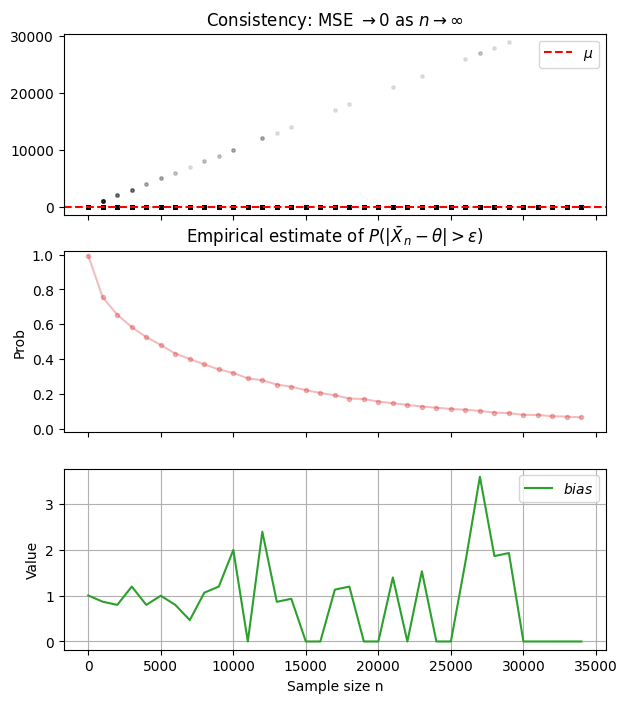

In [ ]:
# Parameters
theta_true = 3.0
sigma = 1.0
ns = np.arange(2, 35_002, step=1000)
eps = 1e-2

estimates = []
bias_emp = []
var_emp = []
mse_emp = []

fig, ax = plt.subplots(3, 1, figsize=(7,8), sharex=True)
ax[0].set_title(r"Consistency: MSE $\rightarrow 0$ as $n\rightarrow \infty$")
ax[0].axhline(y=theta_true, ls='--', color='red', label=r'$\mu$')
ax[0].legend()

# Simulate convergence and bias
for n in ns:
    samples_uniform = np.random.uniform(0, 1, size=(15_000, 1))
    samples_normal = np.random.normal(theta_true, sigma, size=(15_000, n))

    est = samples_normal.mean(axis=1) + n*np.heaviside(1/n - samples_uniform, 1).squeeze(-1)

    estimates.append(est)
    ax[0].scatter(len(est) * [n], est, s=6, alpha=0.1, color="black")

    bias = np.mean(est) - theta_true
    bias_emp.append(bias)

# Compute estimated probs
probs = np.array([np.mean(np.abs(estimates[j] - theta_true) > eps) for j in np.arange(len(ns))])

ax[1].plot(ns, probs, "-o", markersize=3, color="C3", alpha=.3)
ax[1].set_ylabel("Prob")
ax[1].set_title(r"Empirical estimate of $P(|\bar X_n - \theta|>\varepsilon)$")
ax[1].set_ylim(-0.02, 1.02)

ax[2].plot(ns, bias_emp, label=r"$bias$", color="C2")
ax[2].set_xlabel("Sample size n")
ax[2].set_ylabel("Value")
ax[2].legend()
ax[2].grid(True)


❓La figure ci-dessus indique-t-elle que l'estimateur est consistant ?

❓La figure ci-dessus indique-t-elle que la MSE tend vers $0$ ?

❓Quel est la valeur théorique du biais ? Le graphe ci-dessus est-il en accord avec cette valeur théorique ? Pourquoi ?

> 🧠 Écrivez ici ce que vous en pensez !

## Conclusion et pistes de réflexion 💭

Voilà, un troisième notebook de bouclé ! 🎉

Nous avons exploré ensemble les notions de biais et de variance d'un estimateur, ainsi que le compromis qui existe souvent entre les deux ; un principe fondamental en statistiques, également central dans des disciplines dérivées comme le machine learning.

Nous avons passé en revue les notions de fonction de perte (en particulier, les $L^1$ et $L^2$) et de risque associé, nous nous sommes attardés sur la MSE et avons exploré son lien avec le biais et la variance d'un estimateur. Enfin, nous avons vu que la convergence de la MSE constituait un critère suffisant pour la consistance d'un estimateur, critère généralement désiré lorsque l'on cherche à estimer un estimand de la meilleure des manières.

🤔 Nous nous sommes principalement intéressés à des estimateurs simples, comme la moyenne d'échantillon (possiblement avec un paramètre de _shrinkage_).

❓ Mais qu'en est-il d'estimateurs plus complexes, composé d'une somme d'estimateurs, ou d'une fonction d'estimateur(s), par exemple ? Vers quelle(s) distribution(s) tendent de pareils estimateurs ? Je vous renvoie vers les slides pour répondre à ces questions, le Continuous Mapping Theorem et le théorème de Slutsky seront vos amis !

🤔 Nous avons illustré la convergence de la distribution de $\sqrt{n}(\bar{Y}-\mu)$ vers la distribution $\mathcal{N}(0, \sigma^2)$. Mmmmh, cette distribution dépend d'un paramètre (que l'on cherche potentiellement à estimer). En statistiques, nous aurons dans la suite besoin de statistiques suivant une distribution "sans paramètre" (_parameter free_), statistiques que nous appellerons _pivots_ (nous verrons pourquoi pour les intervalles de confiance, par exemple).

❓Ne pourrait-on pas modifier notre statistique pour qu'elle convergence en distribution vers une normale standard $\mathcal{N}(0, 1)$ ? À nouveau, ce cher Eugen Slutsky pourrait bien nous aider...